# How much effort would it take to jump between West Hall and East Hall?

Mellie Zito and Annie Tor

ModSim Section 1, Group 13

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Intial Set-up

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
degree = UNITS.degree

<Unit('degree')>

In [3]:
params = Params(x = 0 * m, #original x position
                y = 12.2 * m, #original y position (12.2 is the height of the edge of West Hall)
                g = 9.8 * m/s**2, #acceleration due to gravity
                mass = 70 * kg, #average mass of a human adult
                diameter = 0.711 * m, #average diameter of a balled-up human (based off Annie)
                rho = 1.2 * kg/m**3, #density of air 
                C_d = 0.47, #drag coefficient of a sphere
                angle = 45 * degree, #initial launch angle
                velocity = 40 * m / s, #initial launch velocity
                t_end = 20 * s) #point at which to end the simulation

,values
x,0 meter
y,12.2 meter
g,9.8 meter / second ** 2
mass,70 kilogram
diameter,0.711 meter
rho,1.2 kilogram / meter ** 3
C_d,0.47
angle,45 degree
velocity,40.0 meter / second
t_end,20 second


In [4]:
def make_system(params):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(params)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    return System(params, init=init, area=area)

In [5]:
def drag_force(V, system):
    """Computes drag force in the opposite direction of `V`.
    
    V: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    mag = -rho * V.mag**2 * C_d * area / 2
    direction = V.hat()
    f_drag = mag * direction
    return f_drag

In [6]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    V = Vector(vx, vy)    
    a_drag = drag_force(V, system) / mass
    a_grav = Vector(0, -g)
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

In [7]:
def event_func(state, t, system):
    """Stop when the y coordinate is 15.74.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    x, y, vx, vy = state
    return y -15.74 * m #height of EH

### Work on this later: 

### Optimal launch angle

To find the launch angle that maximizes distance from home plate, we need a function that takes launch angle and returns range.

In [8]:
def range_func(angle, params):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: distance in meters
    """
    params = Params(params, angle=angle)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func)
    x_dist = get_last_value(results.x) * m
    return x_dist

Let's test `range_func`.

In [9]:
%time range_func(45, params)

Wall time: 113 ms


<Quantity(3.620734499870739, 'meter')>

And sweep through a range of angles.

In [10]:
angles = linspace(20, 80, 21)
sweep = SweepSeries()

for angle in angles:
    x_dist = range_func(angle, params)
    print(angle, x_dist)
    sweep[angle] = x_dist

20.0 10.864802093843126 meter
23.0 9.04338798886407 meter
26.0 7.726336737228438 meter
29.0 6.714629478285232 meter
32.0 5.90453119868965 meter
35.0 5.235526070635512 meter
38.0 4.6695013430664485 meter
41.0 4.18106713808494 meter
44.0 3.7525593800784476 meter
47.0 3.371253117476373 meter
50.0 3.0277126682549644 meter
53.0 2.714766803840082 meter
56.0 2.426846493514953 meter
59.0 2.1595424142395374 meter
62.0 1.909300657688504 meter
65.0 1.673208128431226 meter
68.0 1.4488376141660424 meter
71.0 1.234133489820048 meter
74.0 1.027325698927686 meter
77.0 0.8268635675672372 meter
80.0 0.6313637246087436 meter


Plotting the `Sweep` object, it looks like the peak is between 40 and 45 degrees.

Saving figure to file figs/chap10-fig03.pdf


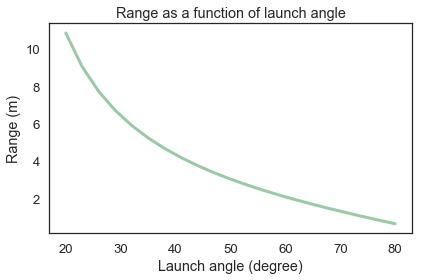

In [11]:
plot(sweep, color='C2')
decorate(xlabel='Launch angle (degree)',
         ylabel='Range (m)',
         title='Range as a function of launch angle',
         legend=False)

savefig('figs/chap10-fig03.pdf')

We can use `max_bounded` to search for the peak efficiently.

In [12]:
%time res = max_bounded(range_func, [0, 90], params)

Wall time: 1.7 s


`res` is an `ModSimSeries` object with detailed results:

In [13]:
res

,values
fun,396.15738499597234 meter
status,0
success,True
message,Solution found.
x,8.98925
nfev,13


`x` is the optimal angle and `fun` the optional range.

In [14]:
optimal_angle = res.x * degree

<Quantity(8.989251206619912, 'degree')>

In [15]:
max_x_dist = res.fun

<Quantity(396.15738499597234, 'meter')>

### Under the hood

Read the source code for `max_bounded` and `min_bounded`, below.

Add a print statement to `range_func` that prints `angle`.  Then run `max_bounded` again so you can see how many times it calls `range_func` and what the arguments are.

In [16]:
%psource max_bounded

In [17]:
%psource min_bounded

### The Manny Ramirez problem

Finally, let's solve the Manny Ramirez problem:

*What is the minimum effort required to hit a home run in Fenway Park?*

Fenway Park is a baseball stadium in Boston, Massachusetts.  One of its most famous features is the "Green Monster", which is a wall in left field that is unusually close to home plate, only 310 feet along the left field line.  To compensate for the short distance, the wall is unusually high, at 37 feet.

Although the problem asks for a minimum, it is not an optimization problem.  Rather, we want to solve for the initial velocity that just barely gets the ball to the top of the wall, given that it is launched at the optimal angle.

And we have to be careful about what we mean by "optimal".  For this problem, we don't want the longest range, we want the maximum height at the point where it reaches the wall.

If you are ready to solve the problem on your own, go ahead.  Otherwise I will walk you through the process with an outline and some starter code.

As a first step, write a function called `height_func` that takes a launch angle and a params as parameters, simulates the flights of a baseball, and returns the height of the baseball when it reaches a point 94.5 meters (310 feet) from home plate.

In [18]:
system = make_system(params)

def event_func(state, t, system):
    """Stop when the x coordinate is 94.5m.
    
    state: State object
    t: time
    system: System object
    
    returns: x coordinate - 94.5m
    """
    x, y, vx, vy = state
    return x - 94.5 * m

event_func(system.init, 0, system)

def height_func(angle, params):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: distance in meters
    """
    params = Params(params, angle=angle)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func)
    y_dist = get_last_value(results.y) * m
    return y_dist

height_func(45 * degree, params)

results = max_bounded(height_func, [0, 90], params)
#should be 44.5

,values
fun,50.90691163642795 meter
status,0
success,True
message,Solution found.
x,54.962
nfev,11


With initial velocity 40 m/s and an optimal launch angle, the ball clears the Green Monster with a little room to spare.

Which means we can get over the wall with a lower initial velocity.

### Finding the minimum velocity

Even though we are finding the "minimum" velocity, we are not really solving a minimization problem.  Rather, we want to find the velocity that makes the height at the wall exactly 11 m, given given that it's launched at the optimal angle.  And that's a job for `fsolve`.

Write an error function that takes a velocity and a `Params` object as parameters.  It should use `max_bounded` to find the highest possible height of the ball at the wall, for the given velocity.  Then it should return the difference between that optimal height and 11 meters.

In [24]:
params = Params(x = 0 * m, 
                y = 1 * m,
                g = 9.8 * m/s**2,
                mass = 145e-3 * kg,
                diameter = 73e-3 * m,
                rho = 1.2 * kg/m**3,
                C_d = 0.3,
                angle = 45 * degree,
                velocity = 40 * m / s,
                t_end = 20 * s)

,values
x,0 meter
y,1 meter
g,9.8 meter / second ** 2
mass,0.145 kilogram
diameter,0.073 meter
rho,1.2 kilogram / meter ** 3
C_d,0.3
angle,45 degree
velocity,40.0 meter / second
t_end,20 second


In [25]:
def error_func2(v, params):
    params.velocity = v * m/s
    system = make_system(params)
    results = max_bounded(height_func, [0, 90], params)
    height = results.fun
    return height - 11 * m

Test your error function before you call `fsolve`.

In [26]:
error_func2(40, params)

<Quantity(0.04782805563812076, 'meter')>

Then use `fsolve` to find the answer to the problem, the minimum velocity that gets the ball out of the park.

In [27]:
fsolve(error_func2, 40, params)

array([39.98806408])

And just to check, run `error_func` with the value you found.

In [28]:
error_func2(39.98806408, params)

<Quantity(6.653905870734889e-09, 'meter')>